Dataset loaded successfully!

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB
None

First 5 rows:
   RowNumber  CustomerId   Sur

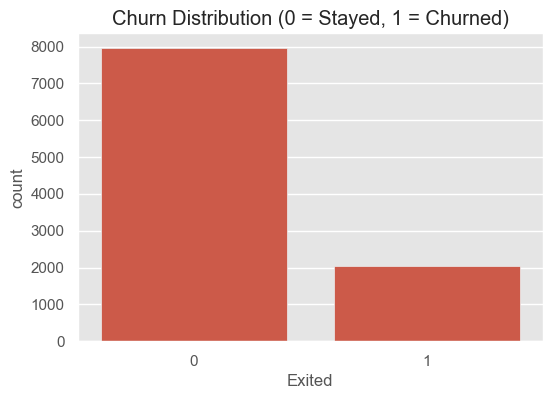

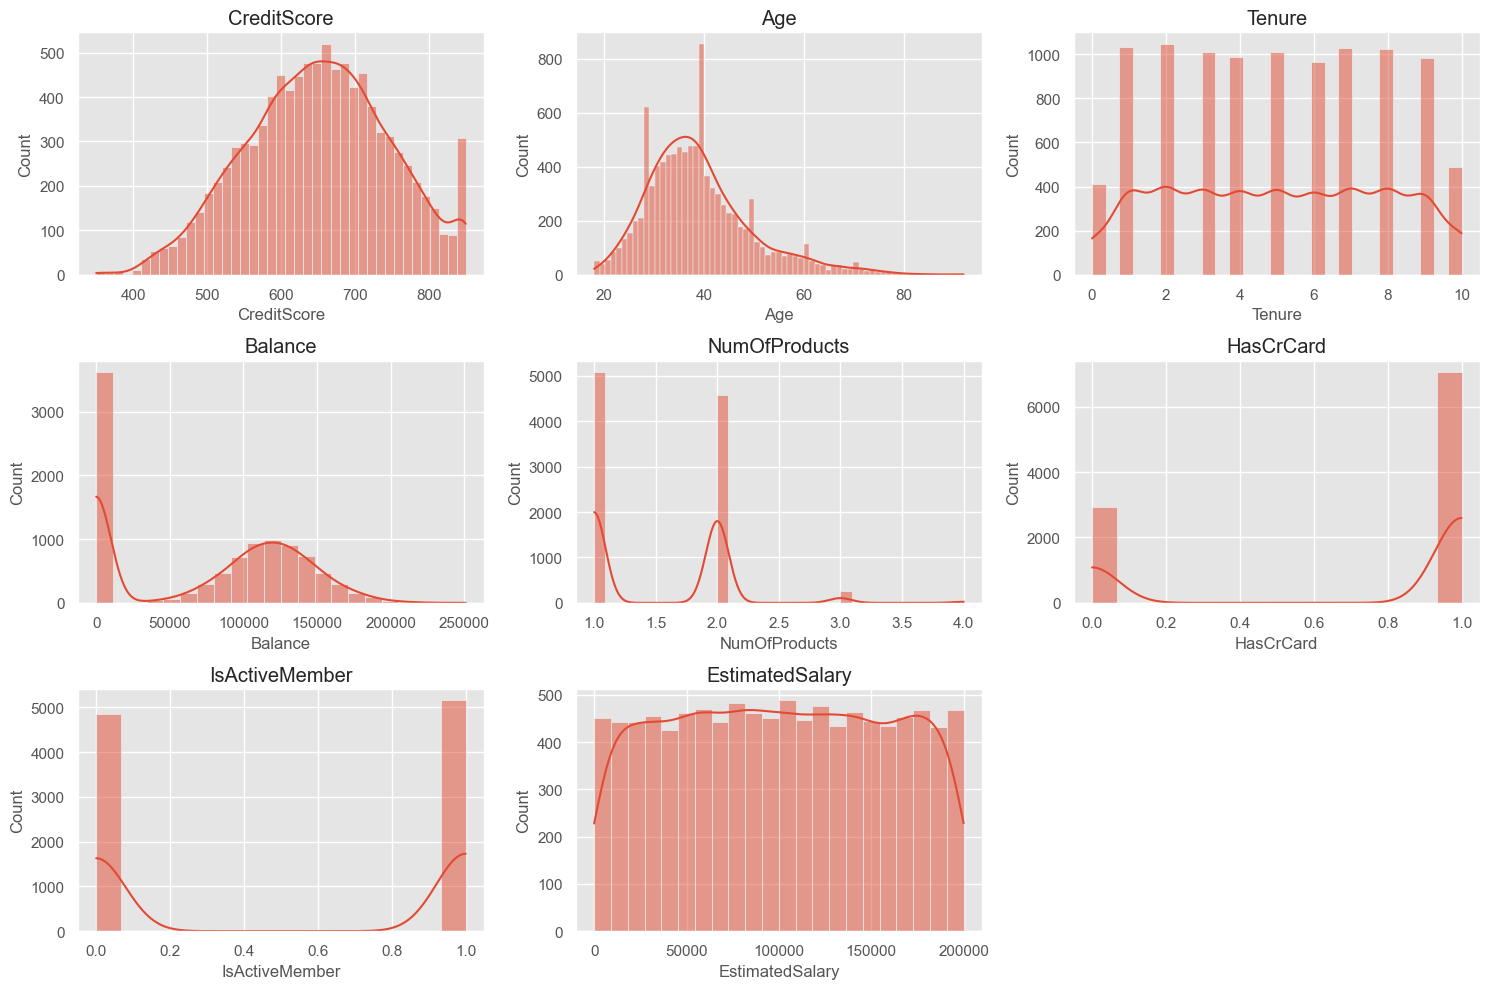

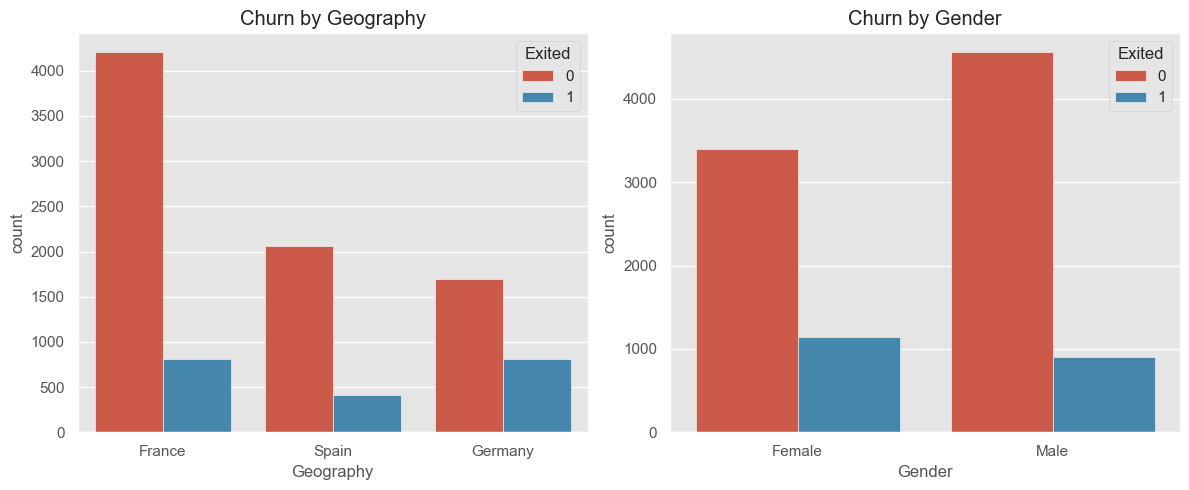

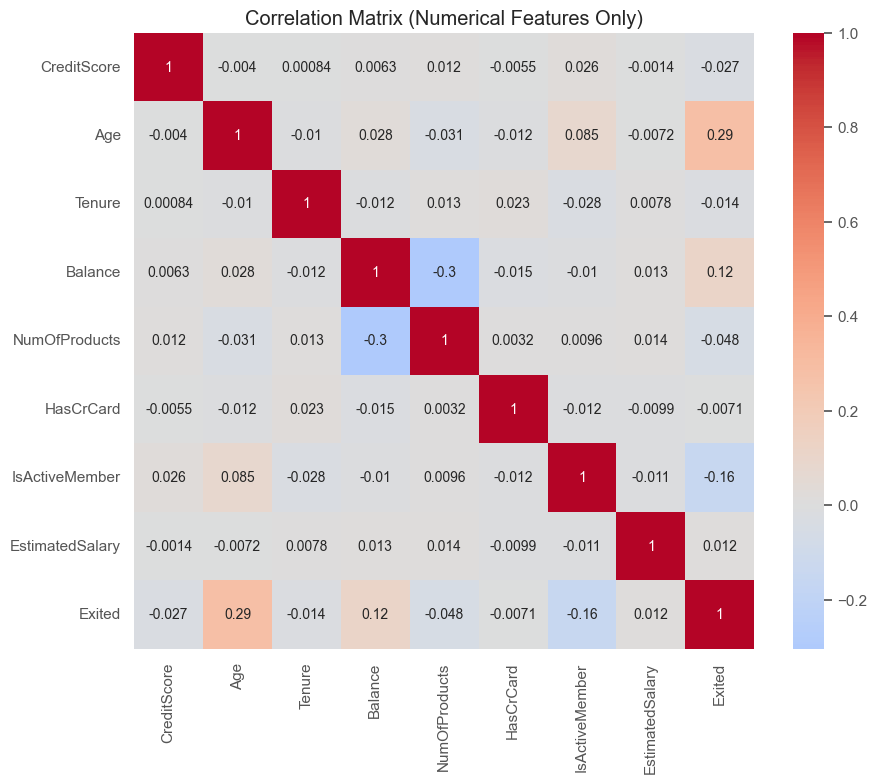


Training Logistic Regression...

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1593
           1       0.39      0.70      0.50       407

    accuracy                           0.71      2000
   macro avg       0.65      0.71      0.65      2000
weighted avg       0.80      0.71      0.74      2000

ROC AUC Score: 0.7772


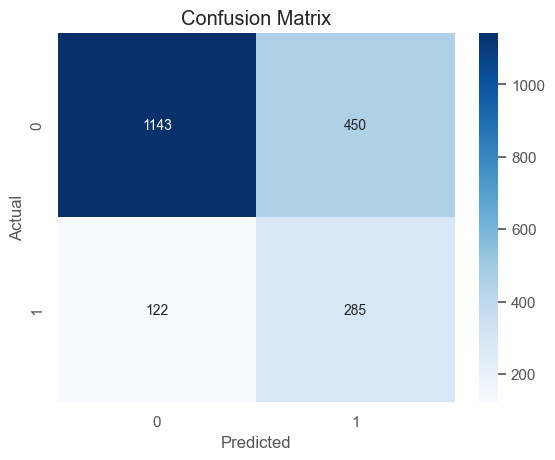

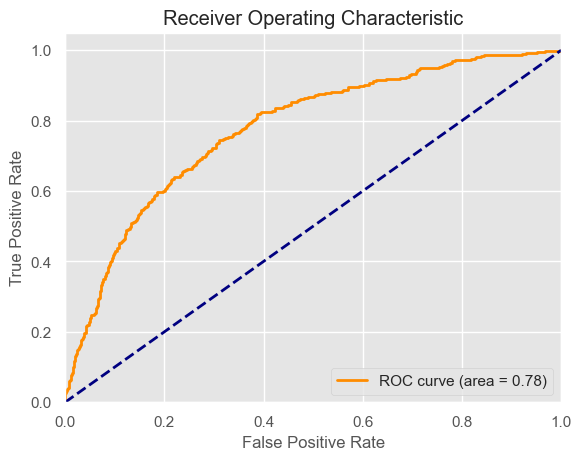


Training Random Forest Classifier...

Best Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1593
           1       0.59      0.65      0.62       407

    accuracy                           0.84      2000
   macro avg       0.75      0.77      0.76      2000
weighted avg       0.84      0.84      0.84      2000

ROC AUC Score: 0.8640


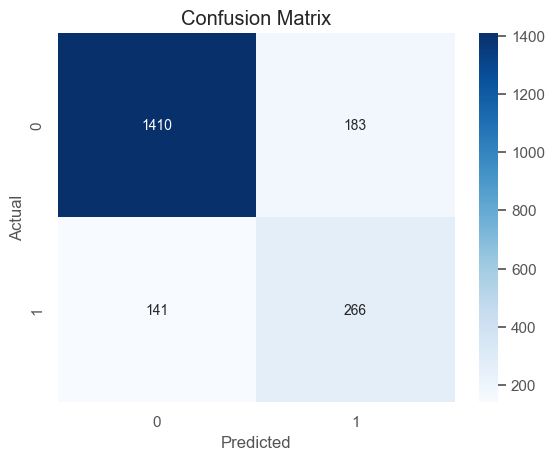

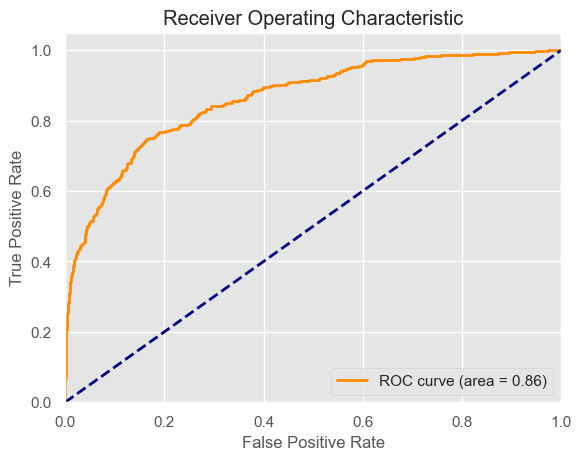


Training Gradient Boosting Classifier...

Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}

Gradient Boosting Performance:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1593
           1       0.79      0.49      0.60       407

    accuracy                           0.87      2000
   macro avg       0.84      0.73      0.76      2000
weighted avg       0.86      0.87      0.86      2000

ROC AUC Score: 0.8708


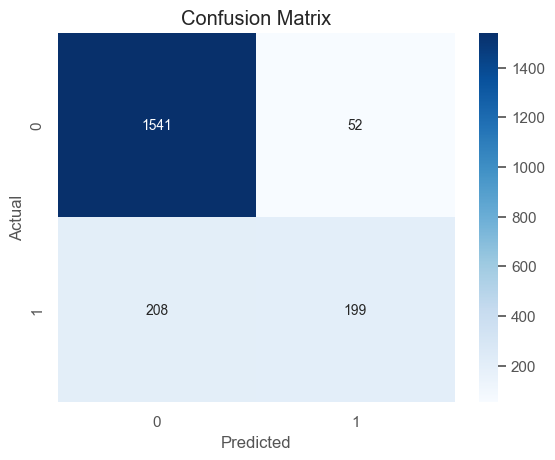

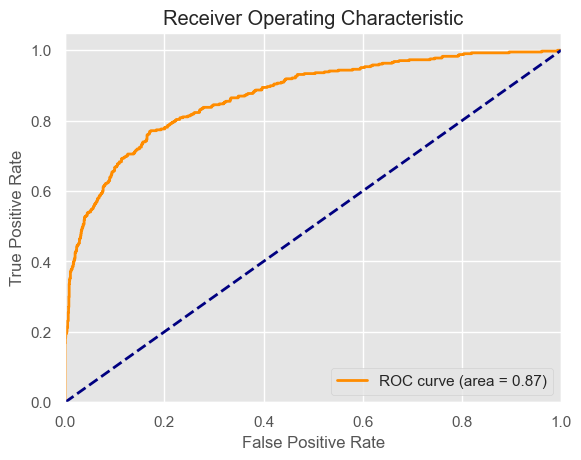

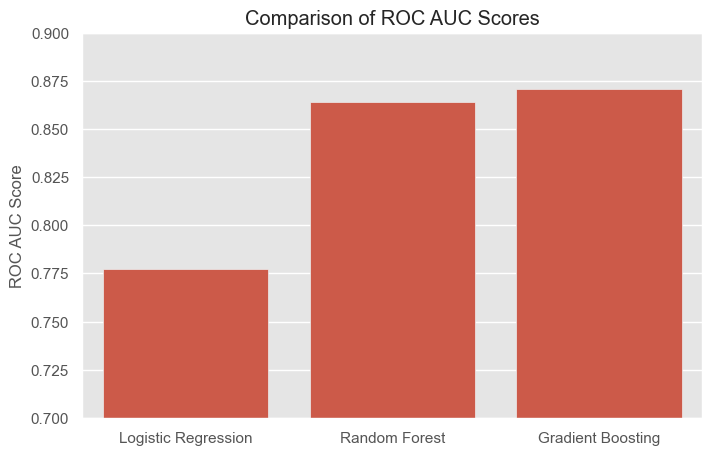

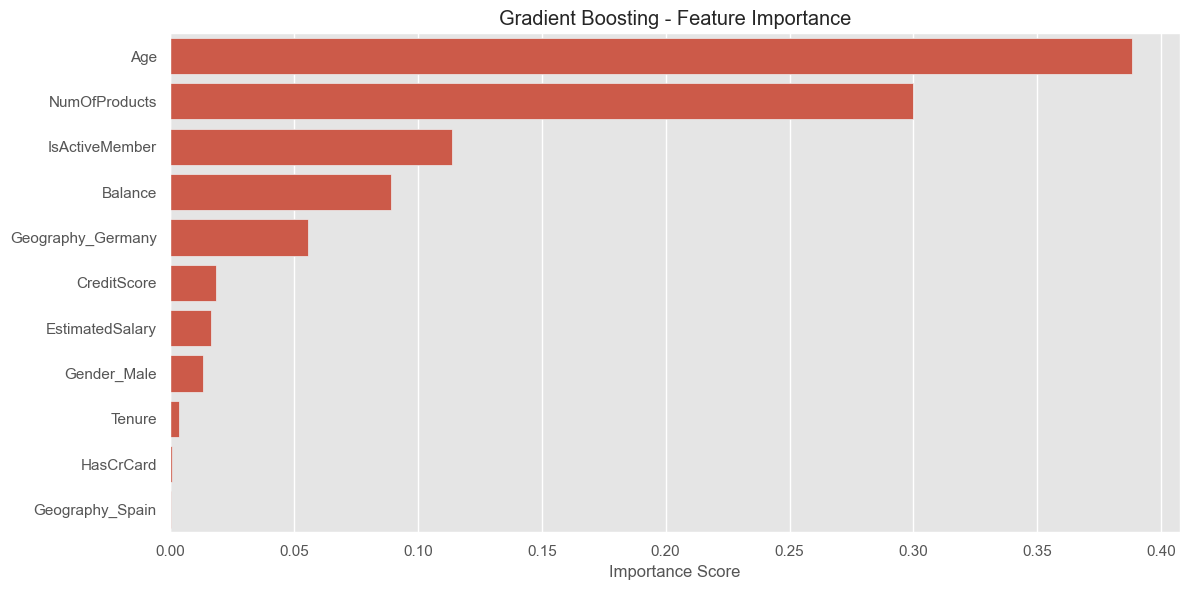


Saving the best model (Gradient Boosting) to disk...
Model saved successfully as 'best_churn_model.joblib'

Key Insights and Recommendations:
1. Top factors contributing to churn:
   - Age: 0.3881
   - NumOfProducts: 0.2999
   - IsActiveMember: 0.1139
   - Balance: 0.0892
   - Geography_Germany: 0.0556
   - CreditScore: 0.0187
   - EstimatedSalary: 0.0165
   - Gender_Male: 0.0132
   - Tenure: 0.0038
   - HasCrCard: 0.0007
   - Geography_Spain: 0.0005

2. Recommended Actions:
   - Target retention efforts on inactive members with high balances
   - Develop special offers for older customers
   - Monitor customers with multiple products who might be overwhelmed
   - Implement early warning systems based on these predictive factors

Example Prediction for a Customer:
      CreditScore Geography Gender  Age  Tenure  Balance  NumOfProducts  \
5702          585    France   Male   36       7      0.0              2   

      HasCrCard  IsActiveMember  EstimatedSalary  
5702          1       

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                            roc_auc_score, accuracy_score, roc_curve, auc)
from joblib import dump
import os

sns.set(style="whitegrid")
plt.style.use('ggplot')

# Load the dataset
try:
    if not os.path.exists('Churn_Modelling.csv'):
        raise FileNotFoundError("File 'Churn_Modelling.csv' not found in the current directory.")
    
    df = pd.read_csv('Churn_Modelling.csv')
    print("Dataset loaded successfully!")
except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Please ensure you have downloaded the dataset from Kaggle and placed it in your working directory.")
    print("Dataset URL: https://www.kaggle.com/datasets/shantanudhakadd/bank-customer-churn-prediction")
    exit()

print("\nDataset Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())
print("\nDescriptive Statistics:")
print(df.describe())

print("\nMissing Values:")
print(df.isnull().sum())

df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

X = df.drop('Exited', axis=1)
y = df['Exited']

cat_cols = ['Geography', 'Gender']
num_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

plt.figure(figsize=(6, 4))
sns.countplot(x='Exited', data=df)
plt.title('Churn Distribution (0 = Stayed, 1 = Churned)')
plt.show()

# Plot numerical features
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

# Plot categorical features vs churn
plt.figure(figsize=(12, 5))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(1, 2, i)
    sns.countplot(x=col, hue='Exited', data=df)
    plt.title(f'Churn by {col}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
corr = df[num_cols + ['Exited']].corr() 
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix (Numerical Features Only)')
plt.show()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first'), cat_cols)
    ])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Function to evaluate models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    return roc_auc

# Logistic Regression
print("\nTraining Logistic Regression...")
logreg_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, class_weight='balanced'))
])

logreg_pipe.fit(X_train, y_train)
print("\nLogistic Regression Performance:")
logreg_auc = evaluate_model(logreg_pipe, X_test, y_test)

# Random Forest Classifier
print("\nTraining Random Forest Classifier...")
rf_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# Hyperparameter tuning
param_grid_rf = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5]
}

grid_rf = GridSearchCV(rf_pipe, param_grid_rf, cv=5, scoring='roc_auc', n_jobs=-1)
grid_rf.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_
print(f"\nBest Parameters: {grid_rf.best_params_}")
print("\nRandom Forest Performance:")
rf_auc = evaluate_model(best_rf, X_test, y_test)

print("\nTraining Gradient Boosting Classifier...")
gb_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# Hyperparameter tuning
param_grid_gb = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__max_depth': [3, 5]
}

grid_gb = GridSearchCV(gb_pipe, param_grid_gb, cv=5, scoring='roc_auc', n_jobs=-1)
grid_gb.fit(X_train, y_train)

best_gb = grid_gb.best_estimator_
print(f"\nBest Parameters: {grid_gb.best_params_}")
print("\nGradient Boosting Performance:")
gb_auc = evaluate_model(best_gb, X_test, y_test)

models = ['Logistic Regression', 'Random Forest', 'Gradient Boosting']
roc_scores = [logreg_auc, rf_auc, gb_auc]

plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=roc_scores)
plt.title('Comparison of ROC AUC Scores')
plt.ylim(0.7, 0.9)
plt.ylabel('ROC AUC Score')
plt.show()

preprocessor.fit(X)
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)
all_features = np.concatenate([num_cols, cat_features])

# Plot feature importance for best model
if gb_auc >= rf_auc and gb_auc >= logreg_auc:
    best_model = best_gb
    model_name = "Gradient Boosting"
    importances = best_model.named_steps['classifier'].feature_importances_
elif rf_auc >= gb_auc and rf_auc >= logreg_auc:
    best_model = best_rf
    model_name = "Random Forest"
    importances = best_model.named_steps['classifier'].feature_importances_
else:
    best_model = logreg_pipe
    model_name = "Logistic Regression"
    importances = np.abs(best_model.named_steps['classifier'].coef_[0])

sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
sns.barplot(x=importances[sorted_idx], y=np.array(all_features)[sorted_idx])
plt.title(f'{model_name} - Feature Importance')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

#Save the Best Model
print(f"\nSaving the best model ({model_name}) to disk...")
dump(best_model, 'best_churn_model.joblib')
print("Model saved successfully as 'best_churn_model.joblib'")

print("\nKey Insights and Recommendations:")
print("1. Top factors contributing to churn:")
for feature, importance in zip(np.array(all_features)[sorted_idx], importances[sorted_idx]):
    print(f"   - {feature}: {importance:.4f}")

print("\n2. Recommended Actions:")
print("   - Target retention efforts on inactive members with high balances")
print("   - Develop special offers for older customers")
print("   - Monitor customers with multiple products who might be overwhelmed")
print("   - Implement early warning systems based on these predictive factors")

# Example prediction
sample_customer = X_test.iloc[[0]]
print("\nExample Prediction for a Customer:")
print(sample_customer)
print(f"\nPredicted Churn Probability: {best_model.predict_proba(sample_customer)[0][1]:.2f}")
print(f"Actual Churn Status: {y_test.iloc[0]}")